# Topics
* [Harris corners](#1)
* [Scale Invariant](#2)
* [Using Differnce of Gaussian](#3)
* [Description of Keypoints](#4)

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

<a id=1></a>
# Harris Corners
>In last [notebook](https://github.com/MahmoudEl-Husseni/Udacity-Introduction-to-Computer-Vision/blob/master/Udacity_Image%20processing_05.ipynb), I discussed Fundmental matrix and how to calculate it from set of corresponding points, but I had to extract these points manually which may be exhausted for large scale, So we need a method that extracts <font color='red'><strong>key points (Features)</strong></font> from image.<br>

#### We can split images parts into three types:
1. Flat area.
2. edges.
3. corners.<br>
The most significant type of these types is corners as we can define any image using its corners, usually there are few corners in image (compared to other two types).

Corners: these parts of images that change in both x, y directions at the same time.

#### How to find corners

first we need to define error function $E(x, y)$, it determine SSD (Sum square difference) of intensities of  origin point and all its neightbors in window $w(x, y).$


$$E(\delta x, \delta y) = \sum_{x, y}{w(x, y) \: [I(x, y) - I(x + \delta x, y + \delta y)]^2}$$
From Taylor expansion, $I(x+\delta x, y+\delta y) = I(x, y) +I_x(x, y) \delta x + I_y(x, y) \delta y$
Where: 
* $I_x$: the first derivative of image in x direction.
* $I_y$: the first derivative of image in y direction.
* $w(x, y): filter applied to pixel at x, y and its neighbors, it's prefered to be gaussian filter.

then
$$E(\delta x, \delta y) = \sum_{x, y}{\delta x^2 I_x^2 + \delta y^2 I_y^2 + 2 \delta x \delta y I_xI_y}$$
this equation is ellipse equation of two variables $I_x, I_y$

<img src='udacity_images/ellipse.jpeg' align='left'></img> 

<br><br><br>
<p align='right'> where: <br>  $\lambda_1: I_x^2$<br> $\lambda_2: I_y^2$</p>
<br><br><br>

we can describe last equation in matrix form:
$$E(\delta x, \delta y) = \begin{bmatrix} \delta x & \delta y \end{bmatrix} 
                          M
                          \begin{bmatrix} \delta x \\ \delta y \end{bmatrix}$$
                          
$$M = w(x, y)\begin{bmatrix} I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix}$$
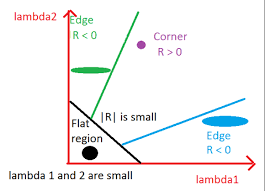
So for image to be a corner both $I_x^2, I_y^2$ should be large.

There are several response functions to evaluate both $I_x^2, I_y^2$ one of the most famous response functions:
$$R = \det(M) - K \times trace (M)^2$$
or 
$$R = \frac{\det (M)}{trace(M)}$$

In [2]:
img = cv.imread('udacity_images/flower.jpeg')

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
WIDTH, HEIGHT = gray.shape
KERNEL_SIZE = 5
K = 0.04
THRESHOLD = 3e4
harris_response_function = lambda M : np.linalg.det(M) - K * (np.trace(M)) ** 2

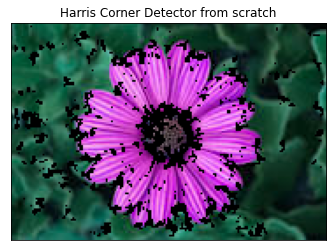

In [3]:
# algorithm without gaussianblur
def harris_corner_detector(img, kernel_size=KERNEL_SIZE, k=K, threshold=THRESHOLD, w_sigma=3):
    global start, WIDTH, HEIGHT
    # calculate dx, dx
    dx = cv.Sobel(img, ddepth=cv.CV_64F, dx=1, dy=0)
    dy = cv.Sobel(img, ddepth=cv.CV_64F, dx=0, dy=1)

    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxy = dx * dy


    # windowing + summing 
    WIDTH, HEIGHT = img.shape
    start = kernel_size // 2
    R = np.zeros((WIDTH-kernel_size+1, HEIGHT-kernel_size+1))
    
    # create gaussian filter
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size), np.linspace(-1, 1, kernel_size))
    w = np.exp(- (x**2 + y**2) / 2*w_sigma**2) / (2*np.pi*w_sigma**2)
    
    for i in range(start, WIDTH-start):
        xwindow_start, xwindow_end = i - start, i + start + 1

        for j in range(start, HEIGHT-start):

            ywindow_start, ywindow_end = j - start, j + start + 1

            sx2 = np.sum(dx2[xwindow_start:xwindow_end, ywindow_start:ywindow_end] * w)
            sy2 = np.sum(dy2[xwindow_start:xwindow_end, ywindow_start:ywindow_end] * w)
            sxy = np.sum(dxy[xwindow_start:xwindow_end, ywindow_start:ywindow_end] * w)

            M = np.matrix([[sx2, sxy], [sxy, sy2]], dtype='float32')
            r = harris_response_function(M)

            R[i-start, j-start] = r

#     cv.normalize(R, R, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    # threshold R
    new_R = np.zeros((*R.shape, 3))
    for i in range(WIDTH-KERNEL_SIZE+1):
        for j in range(HEIGHT-KERNEL_SIZE+1):
            if R[i, j] > threshold:
                new_R[i, j] = [0, 0, 0]
            else :
                new_R[i, j] = [1, 1, 1]
    return new_R
            
R = harris_corner_detector(gray)
new_img = img.copy()
new_img[start:WIDTH-start, start:HEIGHT-start] = new_img[start:WIDTH-start, start:HEIGHT-start] * R
plt.imshow(new_img)
plt.xticks([]), plt.yticks([]), plt.title('Harris Corner Detector from scratch');

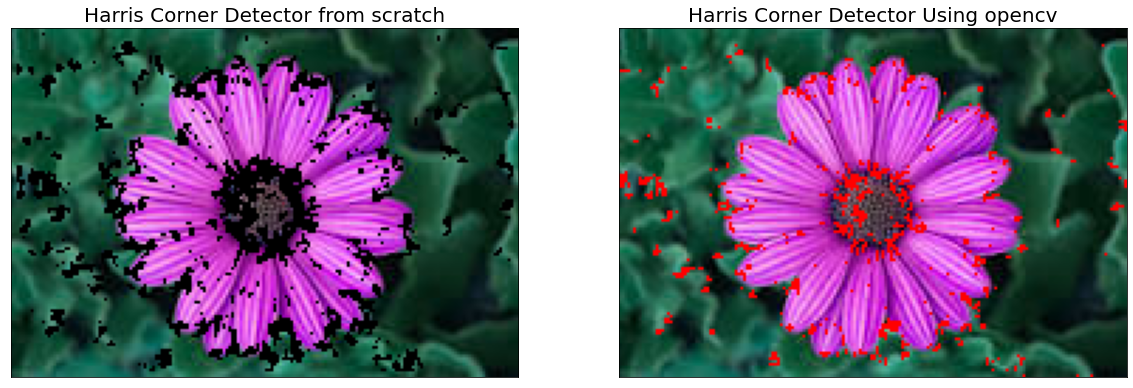

In [4]:
# Using opencv
harris = cv.cornerHarris(gray,2,3,0.04)  # Applies harris corner detector to gray image


# Threshold for an optimal value, it may vary depending on the image.
img[harris>0.01*harris.max()]=[255,0,0]

# visualization
plt.figure(figsize=(20, 12))
plt.subplot(121);
plt.imshow(new_img)
plt.xticks([]), plt.yticks([]), plt.title('Harris Corner Detector from scratch', size=20);

plt.subplot(122)
plt.imshow(img)
plt.xticks([]), plt.yticks([]), plt.title('Harris Corner Detector Using opencv', size=20);


# Scale Invariant
#### Harris Corner Detector algorithm is efficent for almost all image transformations:
It's robust to:
* translation. 
* Rotation.
* Intensity scaling. <br>

<font size=3>But it's <font color='red'>not scale invariant</font> algorithm due to it fixed window size, So it can't detect corners with different scales.</font>

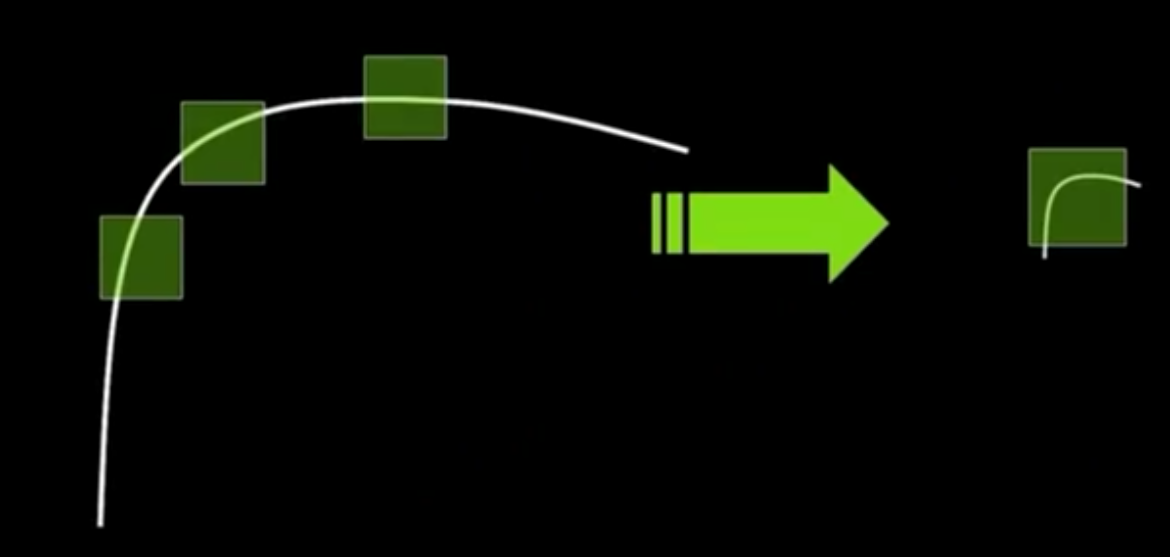
<br>
<font size=3>At the first scale, it wouldn't be able to detect each of these windows as coners, but if we zoomed out it can see the corner now.<br> So we need a method without fixed window size to be scale invariant</font>

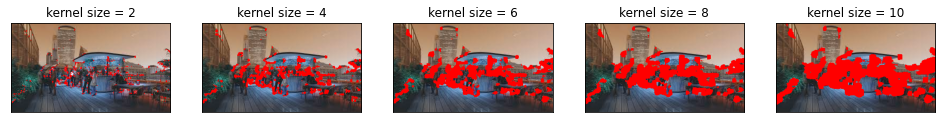

In [5]:
img = cv.imread('udacity_images/restaurant.jpeg')
harris_different_scales = {}
def harris(img, kernel_size):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    harris = cv.cornerHarris(gray,kernel_size,3,0.04)
    harris_different_scales[f'scale_{kernel_size}'] = harris
    painting = img.copy()
    painting[harris>0.01*harris.max()]=[255,0,0]
    return painting

plt.figure(figsize=(20, 12))
for i in range(1, 6):
    plt.subplot(1, 6, i)
    plt.imshow(harris(img, 2*i))
    plt.title(f'kernel size = {2*i}'), plt.xticks([]), plt.yticks([])

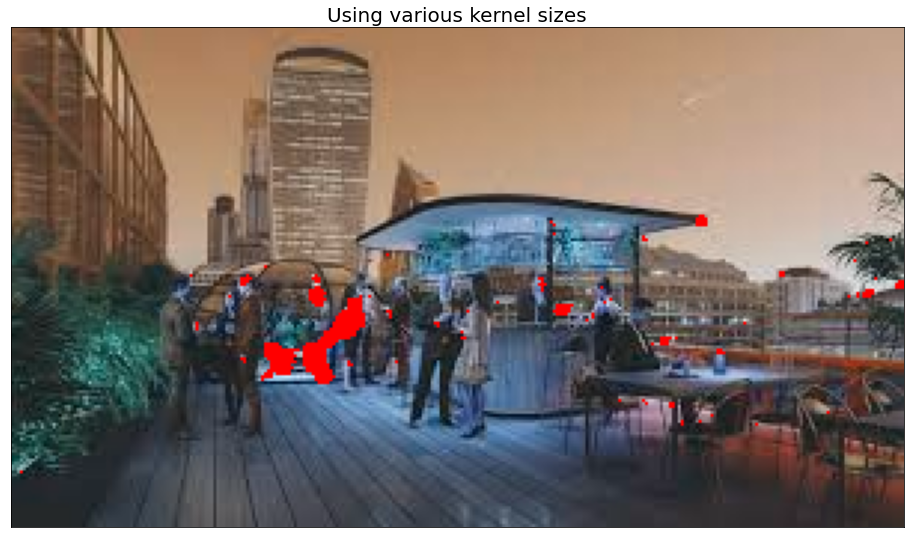

In [6]:
harris_different_scales = np.array([*harris_different_scales.values()])
harris_max_diff = harris_different_scales.max(axis=0)
painting = img.copy()
painting[harris_max_diff>0.09*harris_max_diff.max()] = [255, 0, 0]
plt.figure(figsize=(16, 10))
plt.imshow(painting)
plt.xticks([]), plt.yticks([]), plt.title('Using various kernel sizes', size=20);

<a id=3></a>
# Using Difference of Gaussian
harris cirner with various $\sigma$s worked fine except that:<br>
> $\sigma$ used in harris corner detector with various sigmas is proportional to number of corners detected.

So we need another detection function that doesn't change with sigma.

<font size=2>In this notebook, I will apply  <font color='red'><strong>Difference of Gaussian</strong></font>, $ G(x, y)_{\sigma 1} - G(x, y)_{K \times \sigma 1}$ kernel over the image

    
<img src="udacity_images/DoG.jpeg" align='left'/>
<img src="udacity_images/LoG.png" align='center'/>

For better performance you can use Laplacian of Gaussian function, but it requires high computational power and Difference of Gaussian almost have the same performance.

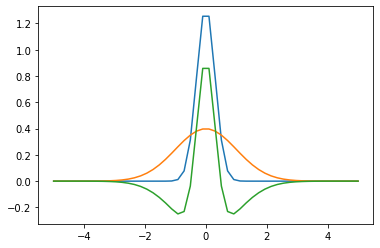

In [7]:
def gaussian(x, sigma):
    kernel =  np.exp(-(x/sigma)**2 / 2) / np.sqrt(np.pi*2*sigma**2)
    return kernel

sigma, kernel_size=3, 50
x = np.linspace(-5, 5)
kernel1= gaussian(x, 0.3)
kernel2 = gaussian(x, 1)

plt.plot(x, kernel1);
plt.plot(x, kernel2)
plt.plot(x, (kernel1-kernel2));

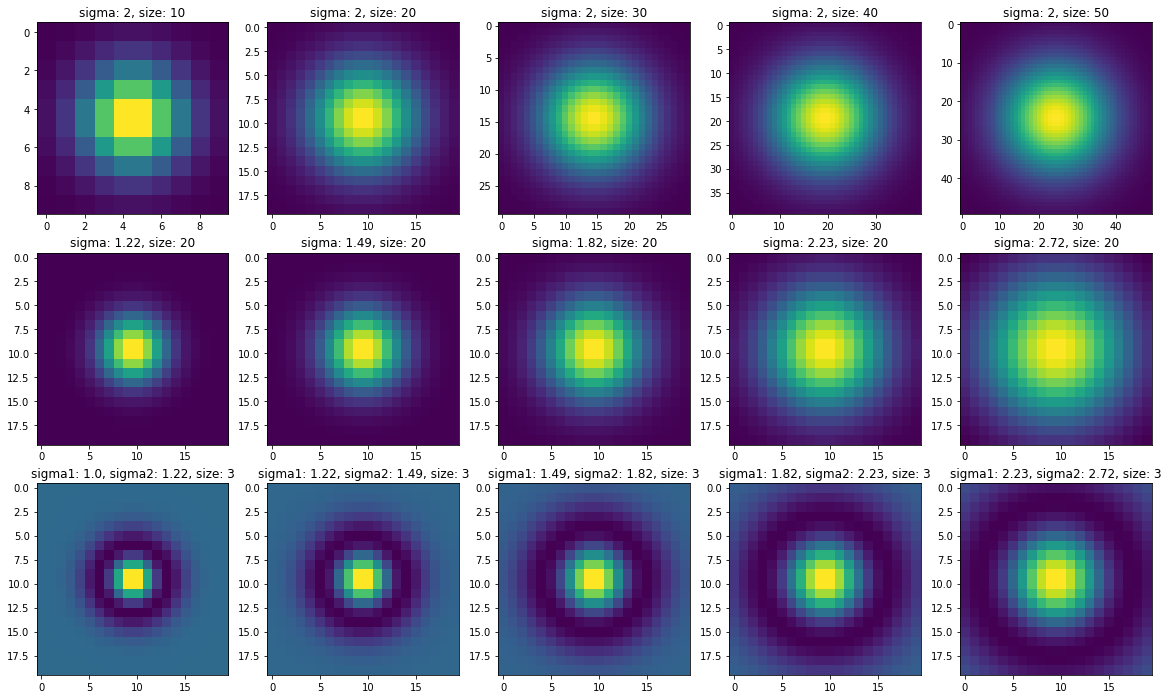

In [8]:
plt.figure(figsize=(20, 12))

# plot gaussian with different kernel sizes
for i in range(5):
    plt.subplot(3, 5, i+1)
    x, y = np.meshgrid(np.linspace(-5, 5, 10*(i+1)), np.linspace(-5, 5, 10*(i+1)))
    z = np.sqrt(x**2 + y**2)
    plt.imshow(gaussian(z, 2))
#     plt.plot(z, gaussian(z, 2)[0])
    plt.title(f'sigma: {2}, size: {10*(i+1)}')
    

# plot gaussian with different kernel sizes
x, y = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
z = np.sqrt(x**2 + y**2)

for i in range(5):
    plt.subplot(3, 5, i+6)
    plt.imshow(gaussian(z, np.exp((i+1)*0.2)))
    plt.title(f'sigma: {np.exp((i+1)*0.2).round(2)}, size: {20}')


# plot Difference of Gaussian
for i in range(5):
    plt.subplot(3, 5, i+11)
    diff = gaussian(z, np.exp((i)*0.2)) - gaussian(z, np.exp((i+1)*0.2))
    plt.imshow(diff)
    plt.title(f'sigma1: {np.exp((i)*0.2).round(2)}, sigma2: {np.exp((i+1)*0.2).round(2)}, size: {3}')
    
    
def DoG(img, n_octaves=4, kernel_size=5):
    global img_, blurred_im
    octave_corners = {}
    x, y = np.meshgrid(np.linspace(-5, 5, 5), np.linspace(-5, 5, 5))
    z = np.sqrt(x**2 + y**2)
    for octave in range(n_octaves):
        sigma1, sigma2 = np.exp((octave)*0.3), (np.exp((octave+1)*0.3)**2)
        kernel1 = gaussian(z, sigma1)
        kernel2 = gaussian(z, sigma2)
        
        blurred_im = cv.filter2D(img, -1, kernel2)
        img_ = cv.filter2D(img, -1, kernel1)
        
        octave_corners[f'octave_{octave}'] = img_ - blurred_im
    return octave_corners

gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
corners = DoG(gray)

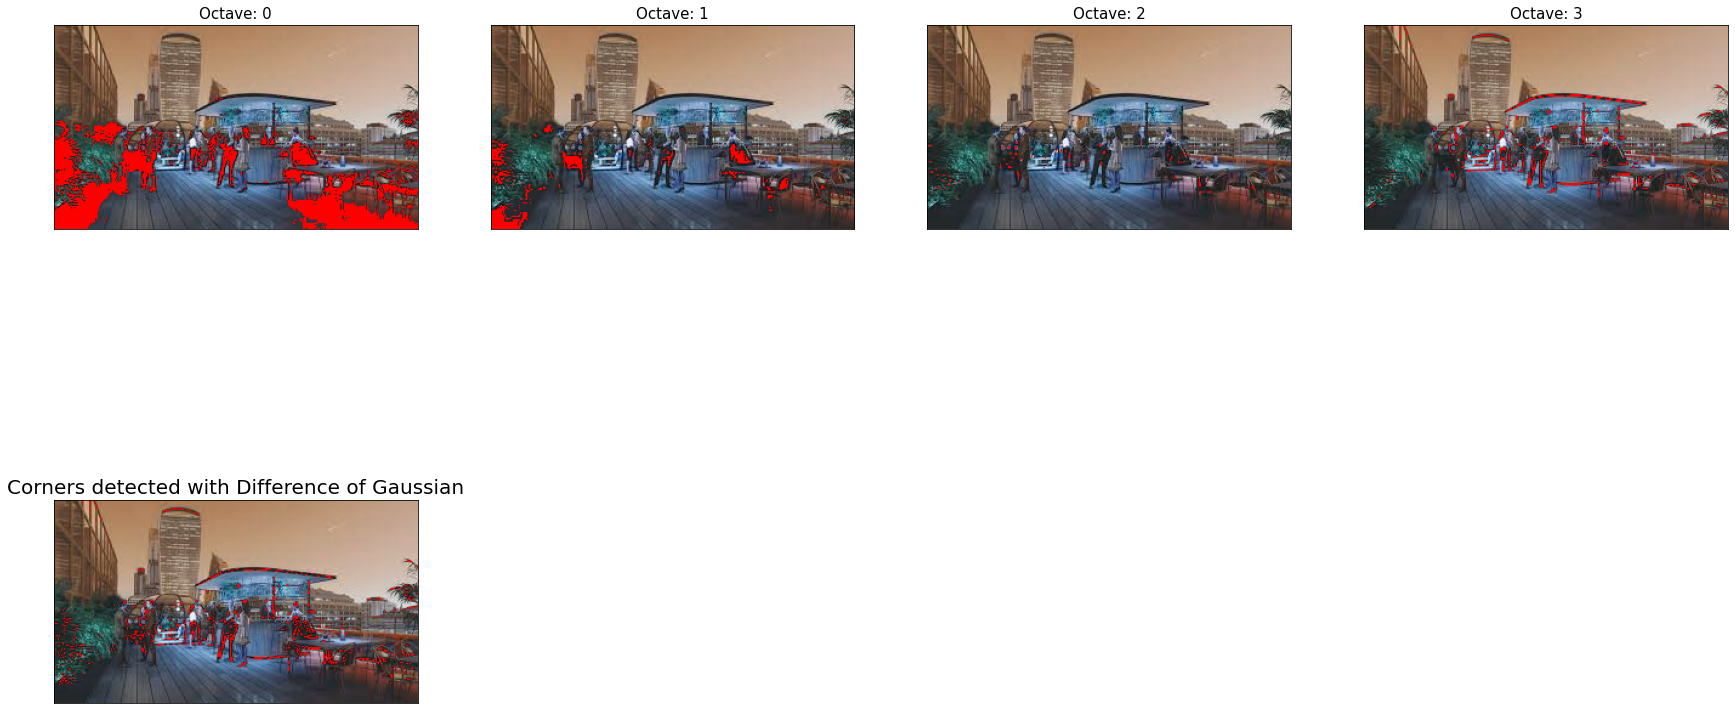

In [9]:
plt.figure(figsize=(30, 16))
for i in range(len(corners)):
    painting = img.copy()
    painting[corners[f'octave_{i}']>0.95*corners[f'octave_{i}'].max()] = [255, 0, 0]
    plt.subplot(2, len(corners), i+1)
    plt.imshow(painting)
    plt.title(f'Octave: {i}', size=15), plt.xticks([]), plt.yticks([])
    
    
corners_arr = np.array([*corners.values()])
corners_total = corners_arr.max(0)

plt.subplot(245)
painting = img.copy()
painting[corners_total > 0.97*corners_total.max()] = [255, 0, 0]
plt.imshow(painting)
plt.title('Corners detected with Difference of Gaussian', size=20), plt.xticks([]), plt.yticks([]);
plt.imsave('DoG1.png', painting)

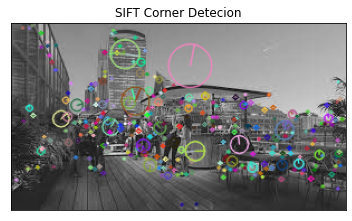

In [10]:
# using opencv
sift = cv.SIFT_create()
key_pts = sift.detect(gray)
img_ = cv.drawKeypoints(gray, key_pts, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_)
plt.xticks([]), plt.yticks([]), plt.title('SIFT Corner Detecion');

### Edges and Corners 
DoG finds both edges and corners so we need to define function that filter only corners and remove edges

<a id=4></a>
# Description of Keypoints:

Remeber our goal is to find corresponding points in stearo images, we managed to find corners in both images.

Now we need to describe each point to be able to find it correpondence in the other image.


To describe key points we need to define a descriptor: <br>
```Orientation assignment```: For a fixed keypoint we calculate <font color='red'>gradient <strong>magnitude</strong> and <strong>direction</strong></font> then we sparse direction in 8 directions (right, left, up, down, right-up, right-down, left-up, left-down) and create a histogram of these groups to know the <font color='red'><strong>Dominant Direction</strong></font>

`Descriptor`: For each keypoint, we would have a $16 \times 16$ centered at this keypoint and, we should divide this window ito 16 $4 \times 4$ windows and perform Orientation Assignment to each window, now we get a vector of $4 \times 4 \times 8$ for each keypoint (represent each keypoint with 128 value).


In [11]:
# calculate descriptors
# kp: key points , des: descriptor of each keypoint
kp, des = sift.compute(gray, key_pts)
print(f'Number of Keypoints: {len(kp)}, Number of values in each descriptor {des.shape[1]}')

Number of Keypoints: 344, Number of values in each descriptor 128
